**Q. No 1. Variational Autoencoders**

100%|██████████| 170498071/170498071 [00:04<00:00, 42026697.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch 1, Recon Loss: 24420.2687078125, KL Loss: 1793.8164566880225
Epoch 2, Recon Loss: 16975.74913125, KL Loss: 2216.07214375
Epoch 3, Recon Loss: 15453.3863125, KL Loss: 2409.711385546875
Epoch 4, Recon Loss: 14686.97698125, KL Loss: 2577.149991015625
Epoch 5, Recon Loss: 14251.4006421875, KL Loss: 2674.672280859375
Epoch 6, Recon Loss: 13874.52216875, KL Loss: 2797.238962890625
Epoch 7, Recon Loss: 13584.70945, KL Loss: 2906.2078390625
Epoch 8, Recon Loss: 13408.1922375, KL Loss: 2975.337705859375
Epoch 9, Recon Loss: 13274.322071875, KL Loss: 3022.912176953125
Epoch 10, Recon Loss: 13176.1694875, KL Loss: 3058.76793046875


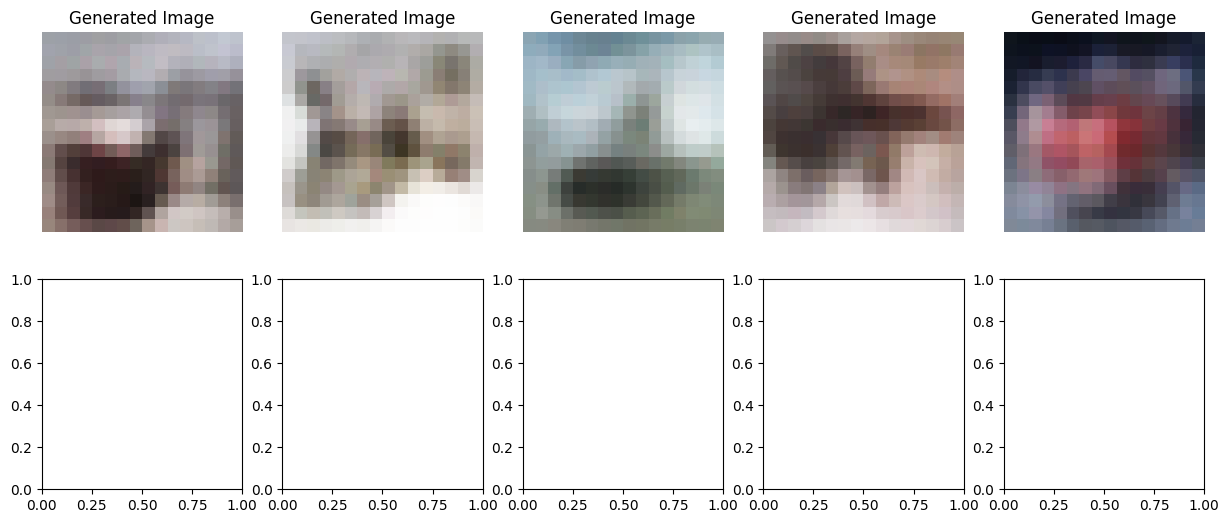

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np

# Define VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_dim[0], out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Mean and variance layers for latent representation
        self.fc_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(256 * 2 * 2, latent_dim)


        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_dim[0], kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        z = z.view(z.size(0), self.latent_dim, 1, 1)
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Define loss function
def vae_loss(recon_x, x, mu, logvar, beta=1):
    recon_x = nn.functional.interpolate(recon_x, size=x.size()[2:], mode='bilinear', align_corners=False)
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_divergence

# Data preprocessing and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, transform=transform)

# Splitting dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, _ = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the VAE model
input_dim = (3, 32, 32)
latent_dim = 64
vae_model = VAE(input_dim, latent_dim)

# Define optimizer
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
recon_losses = []
kl_losses = []

for epoch in range(num_epochs):
    vae_model.train()
    total_recon_loss = 0.0
    total_kl_loss = 0.0

    for batch_idx, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_images, mu, logvar = vae_model(images)
        loss = vae_loss(recon_images, images, mu, logvar, beta=1)
        loss.backward()
        optimizer.step()

        total_recon_loss += loss.item()
        total_kl_loss += -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).item()

    recon_losses.append(total_recon_loss / len(train_loader))
    kl_losses.append(total_kl_loss / len(train_loader))

    print(f"Epoch {epoch+1}, Recon Loss: {recon_losses[-1]}, KL Loss: {kl_losses[-1]}")

# Visualize 5 randomly selected generated images and 5 real images
def generate_images(vae_model, num_images=5):
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim)
        generated_images = vae_model.decode(z)
    return generated_images

vae_model.eval()
generated_images = generate_images(vae_model, num_images=5)

num_test_images = len(test_dataset)
indices = np.random.choice(num_test_images, size=5, replace=False)
real_images = torch.stack([test_dataset[i][0] for i in indices])

def denormalize(img):
    img = img * 0.5 + 0.5
    np_img = img.numpy()
    np_img = np.transpose(np_img, (1, 2, 0))
    return np_img

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(denormalize(generated_images[i]))
    axes[0, i].axis('off')
    axes[0, i].set_title('Generated Image')



**Q. No 2. Conditional Variational Autoencoders**

In [ ]:
# pip install tensorflow numpy matplotlib

Epoch: 1, Loss: 2088.2017


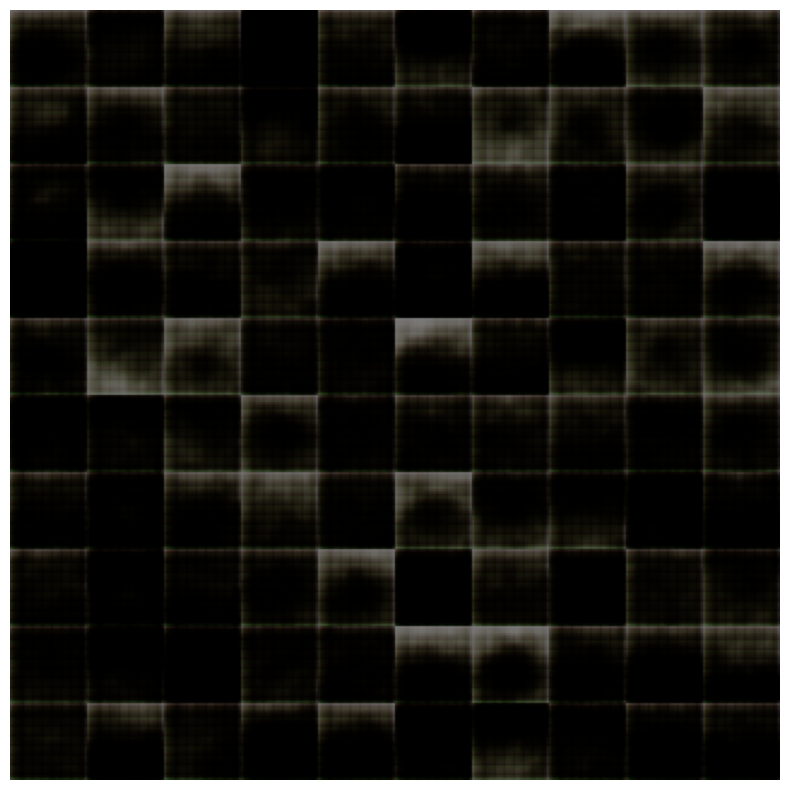

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

latent_dim = 128

class CVAE(keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(32, 32, 3 + 10)),
            layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'),
            layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim + 10,)),
            layers.Dense(units=8*8*128, activation=tf.nn.relu),
            layers.Reshape(target_shape=(8, 8, 128)),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(3, kernel_size=3, strides=1, activation='sigmoid', padding='same'),
        ])

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# Step 6: Define the loss function for CVAE
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -0.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis
    )

def compute_loss(model, x, y):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(tf.concat([z, y], axis=1))
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x[:,:,:,0:3])
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


# Step 7: Set up optimizer and training step
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 1
batch_size = 128

# Step 8: Training loop
model = CVAE(latent_dim)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(len(x_val)).batch(batch_size)

def train_step(model, x, y, optimizer):
    y = tf.cast(y, tf.float32)
    y_expanded = tf.expand_dims(tf.expand_dims(y, 1), 2)
    y_tiled = tf.tile(y_expanded, [1, 32, 32, 1])
    x_with_labels = tf.concat([x, y_tiled], axis=-1)
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x_with_labels, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def generate_and_save_images(model, epoch, test_input, labels):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(10, 10, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

for epoch in range(1, epochs + 1):
    for train_x, train_y in train_dataset:
        train_loss = train_step(model, train_x, train_y, optimizer)
    print('Epoch: {}, Loss: {:.4f}'.format(epoch, train_loss))

    if epoch % 10 == 0:
        test_loss = tf.keras.metrics.Mean()
        for test_x, test_y in test_dataset:
            test_loss(compute_loss(model, test_x, test_y))
        print('Epoch: {}, Test Loss: {:.4f}'.format(epoch, test_loss.result()))
        generate_and_save_images(model, epoch, x_test[:100], y_test[:100])

# Step 9: Generate and display some images
n = 10
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n, 3))

grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.random.normal(size=(1, latent_dim))
        label = np.zeros((1, 10))
        label[0, np.random.randint(10)] = 1
        z = tf.concat([z, label], axis=1)
        x_decoded = model.decode(z)
        digit = tf.reshape(x_decoded[0], (digit_size, digit_size, 3))
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.numpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.axis('off')
plt.show()


**Q. No 3. VAE Encoder as Feature Extractor for Classification**

Epoch: 1, Loss: 2079.6150
Epoch 1/20
313/313 [==============================] - 5s 12ms/step - loss: 0.0170 - accuracy: 0.9953 - val_loss: 1.7714e-08 - val_accuracy: 1.0000
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 1.3849e-08 - accuracy: 1.0000 - val_loss: 5.7220e-09 - val_accuracy: 1.0000
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 5.4717e-09 - accuracy: 1.0000 - val_loss: 3.0398e-09 - val_accuracy: 1.0000
Epoch 4/20
313/313 [==============================] - 3s 9ms/step - loss: 3.0368e-09 - accuracy: 1.0000 - val_loss: 1.6928e-09 - val_accuracy: 1.0000
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 1.8358e-09 - accuracy: 1.0000 - val_loss: 1.0967e-09 - val_accuracy: 1.0000
Epoch 6/20
313/313 [==============================] - 3s 10ms/step - loss: 1.2040e-09 - accuracy: 1.0000 - val_loss: 7.6294e-10 - val_accuracy: 1.0000
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss:

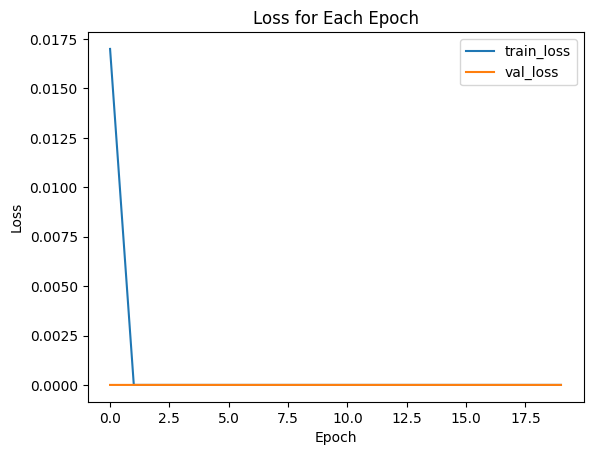

313/313 [==============================] - 1s 3ms/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000


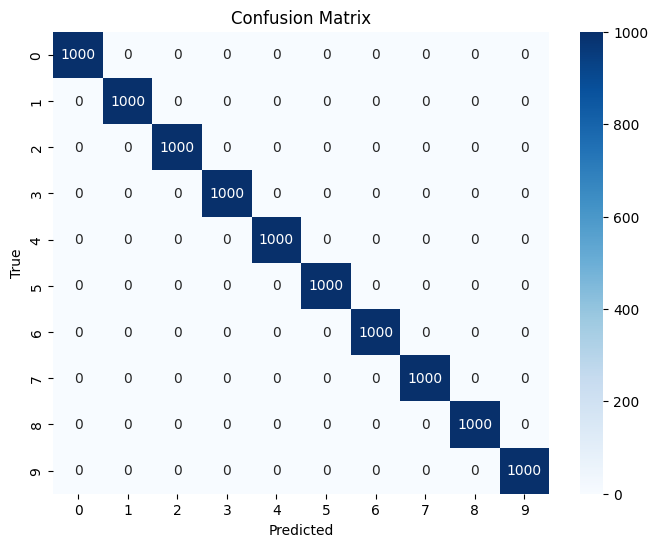

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

latent_dim = 128

class CVAE(keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(32, 32, 13)),
            layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'),
            layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim),
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim + 10,)),
            layers.Dense(units=8*8*128, activation=tf.nn.relu),
            layers.Reshape(target_shape=(8, 8, 128)),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(3, kernel_size=3, strides=1, activation='sigmoid', padding='same'),
        ])

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# Define the loss function for CVAE
def compute_loss(model, x, y):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(tf.concat([z, y], axis=1))
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x[:,:,:,0:3])
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# Define a function to compute log normal PDF
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -0.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis
    )

# Set up the optimizer and training step
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 1
batch_size = 128

# Training loop for CVAE
model = CVAE(latent_dim)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(len(x_val)).batch(batch_size)

def train_step(model, x, y, optimizer):
    y_expanded = tf.expand_dims(tf.expand_dims(y, 1), 2)
    y_tiled = tf.tile(y_expanded, [1, 32, 32, 1])
    x_with_labels = tf.concat([x, y_tiled], axis=-1)
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x_with_labels, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

for epoch in range(1, epochs + 1):
    for train_x, train_y in train_dataset:
        train_loss = train_step(model, train_x, train_y, optimizer)
    print(f'Epoch: {epoch}, Loss: {train_loss:.4f}')

# Define the classifier model
class ClassifierModel(keras.Model):
    def __init__(self, encoder, latent_dim):
        super(ClassifierModel, self).__init__()
        self.encoder = encoder
        self.classifier = layers.Dense(10, activation='softmax')

    def call(self, x):
        encoded = self.encoder(x)
        mean, _ = tf.split(encoded, num_or_size_splits=2, axis=1)
        return self.classifier(mean)

# Instantiate the classifier model using the encoder from the CVAE
cvae_encoder = model.encoder
classifier_model = ClassifierModel(cvae_encoder, latent_dim)

# Compile the classifier model
classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the function to concatenate labels with images
def concatenate_labels(x, y):
    y_expanded = tf.expand_dims(tf.expand_dims(y, axis=1), axis=2)
    y_tiled = tf.tile(y_expanded, [1, 32, 32, 1])
    x_with_labels = tf.concat([x, y_tiled], axis=-1)
    return x_with_labels

# Train the classifier model
history = classifier_model.fit(
    x=concatenate_labels(x_train, y_train),
    y=y_train,
    epochs=20,
    batch_size=128,
    validation_data=(concatenate_labels(x_val, y_val), y_val)
)

# Plot loss for each epoch
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for Each Epoch')
plt.legend()
plt.show()

# Evaluate the classifier model
y_pred = classifier_model.predict(concatenate_labels(x_test, y_test))

# Calculate accuracy, precision, recall, and F-measure
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
precision = precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
recall = recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
f1 = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Measure: {f1:.4f}")

# Plot the confusion matrix using seaborn
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(conf_matrix, index=range(10), columns=range(10))

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Q. No 4. GAN Implementation**

Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[0/10][0/625] Loss_D: 1.5258 Loss_G: 3.7409 D(x): 0.5963
[0/10][100/625] Loss_D: 1.4665 Loss_G: 3.1145 D(x): 0.3220
[0/10][200/625] Loss_D: 0.5076 Loss_G: 2.1754 D(x): 0.6825
[0/10][300/625] Loss_D: 0.2382 Loss_G: 4.7882 D(x): 0.8902
[0/10][400/625] Loss_D: 0.0185 Loss_G: 10.2181 D(x): 0.9824
[0/10][500/625] Loss_D: 0.2248 Loss_G: 3.2660 D(x): 0.8776
[0/10][600/625] Loss_D: 0.5377 Loss_G: 3.3330 D(x): 0.9725


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1/10][0/625] Loss_D: 0.6333 Loss_G: 2.5755 D(x): 0.6043
[1/10][100/625] Loss_D: 1.3566 Loss_G: 6.3194 D(x): 0.3326
[1/10][200/625] Loss_D: 0.3742 Loss_G: 3.4489 D(x): 0.8005
[1/10][300/625] Loss_D: 0.3389 Loss_G: 5.3796 D(x): 0.9527
[1/10][400/625] Loss_D: 0.1764 Loss_G: 3.2087 D(x): 0.8867
[1/10][500/625] Loss_D: 0.0974 Loss_G: 4.1476 D(x): 0.9696
[1/10][600/625] Loss_D: 1.0405 Loss_G: 1.0450 D(x): 0.4467
[2/10][0/625] Loss_D: 0.2398 Loss_G: 2.8017 D(x): 0.8439
[2/10][100/625] Loss_D: 0.0704 Loss_G: 3.9778 D(x): 0.9582
[2/10][200/625] Loss_D: 1.6196 Loss_G: 4.4730 D(x): 0.9829
[2/10][300/625] Loss_D: 0.0327 Loss_G: 4.5310 D(x): 0.9757
[2/10][400/625] Loss_D: 0.3730 Loss_G: 3.0107 D(x): 0.7894
[2/10][500/625] Loss_D: 0.9627 Loss_G: 4.8552 D(x): 0.9576
[2/10][600/625] Loss_D: 0.1896 Loss_G: 3.9898 D(x): 0.9497
[3/10][0/625] Loss_D: 0.0753 Loss_G: 6.9455 D(x): 0.9340
[3/10][100/625] Loss_D: 0.3616 Loss_G: 4.6688 D(x): 0.9616
[3/10][200/625] Loss_D: 0.1445 Loss_G: 3.3619 D(x): 0.9259
[3/

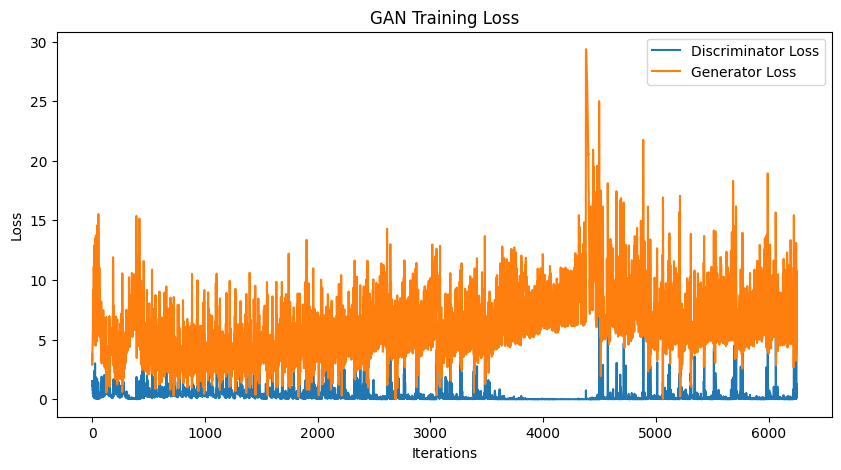

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Data preprocessing and normalization
image_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=image_transform)
train_data_size = int(0.8 * len(dataset))
train_data, val_data = torch.utils.data.random_split(dataset, [train_data_size, len(dataset) - train_data_size])

def create_data_loader(data, batch_size, shuffle, num_workers):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

train_loader = create_data_loader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_loader = create_data_loader(val_data, batch_size=64, shuffle=False, num_workers=2)

# Generator and Discriminator architecture
class ImageGenerator(nn.Module):
    def __init__(self, latent_dim, gen_filters, num_channels):
        super().__init__()
        self.gen_model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, gen_filters * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_filters * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_filters * 8, gen_filters * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_filters * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_filters * 4, gen_filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_filters * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_filters * 2, gen_filters, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_filters),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_filters, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.gen_model(input)

class ImageDiscriminator(nn.Module):
    def __init__(self, num_channels, disc_filters):
        super().__init__()
        self.disc_model = nn.Sequential(
            nn.Conv2d(num_channels, disc_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(disc_filters, disc_filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_filters * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(disc_filters * 2, disc_filters * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_filters * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(disc_filters * 4, disc_filters * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_filters * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(disc_filters * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.disc_model(input)

# Hyperparameters and device configuration
learning_rate = 0.0002
batch_sz = 64
epochs = 10
beta1 = 0.5
latent_dim = 100
gen_filters = 64
disc_filters = 64
num_channels = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = ImageGenerator(latent_dim, gen_filters, num_channels).to(device)
discriminator = ImageDiscriminator(num_channels, disc_filters).to(device)

# Define loss function and optimizers
loss_function = nn.BCELoss()
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
opt_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Training loop
def train_gan(num_epochs, train_loader, device, generator, discriminator, loss_function, opt_generator, opt_discriminator):
    disc_losses, gen_losses = [], []

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            real_images = real_images.to(device)

            # Train Discriminator with real images
            discriminator.zero_grad()
            real_labels = torch.full((batch_sz,), 1., device=device)
            output = discriminator(real_images).view(-1)
            disc_loss_real = loss_function(output, real_labels)
            disc_loss_real.backward()
            discriminator_mean = output.mean().item()

            # Train Discriminator with fake images
            noise = torch.randn(batch_sz, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)
            fake_labels = torch.zeros(batch_sz, device=device)
            output = discriminator(fake_images.detach()).view(-1)
            disc_loss_fake = loss_function(output, fake_labels)
            disc_loss_fake.backward()
            opt_discriminator.step()

            # Train Generator
            generator.zero_grad()
            real_labels.fill_(1.)
            output = discriminator(fake_images).view(-1)
            gen_loss = loss_function(output, real_labels)
            gen_loss.backward()
            opt_generator.step()

            # Store losses
            disc_losses.append(disc_loss_real.item() + disc_loss_fake.item())
            gen_losses.append(gen_loss.item())

            if i % 100 == 0:
                print(f'[{epoch}/{num_epochs}][{i}/{len(train_loader)}] Loss_D: {disc_loss_real.item() + disc_loss_fake.item():.4f} Loss_G: {gen_loss:.4f} D(x): {discriminator_mean:.4f}')

    return disc_losses, gen_losses

# Plotting the loss curves
def plot_loss_curves(disc_losses, gen_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.plot(gen_losses, label='Generator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.show()

# Run the training
disc_losses, gen_losses = train_gan(epochs, train_loader, device, generator, discriminator, loss_function, opt_generator, opt_discriminator)

plot_loss_curves(disc_losses, gen_losses)


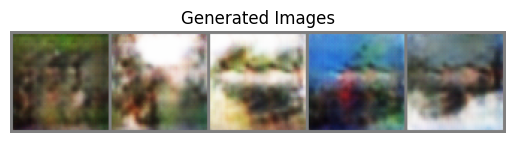

Files already downloaded and verified


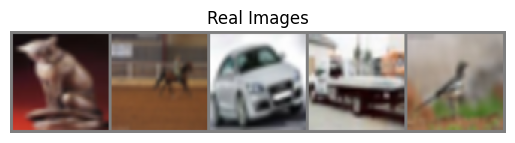

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images with titles
def display_images(image, title):
    image = image * 0.5 + 0.5
    numpy_image = image.cpu().numpy()
    plt.imshow(np.transpose(numpy_image, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate and display five fake images
num_fake_images = 5
random_noise = torch.randn(num_fake_images, latent_dim, 1, 1, device=device)
generated_images = generator(random_noise)
display_images(torchvision.utils.make_grid(generated_images[:num_fake_images]), title="Generated Images")

# Load CIFAR-10 test dataset and display five real images
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=image_transform)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=num_fake_images, shuffle=True, num_workers=2)

# Get a batch of data from the DataLoader
data_iterator = iter(test_data_loader)
real_images_batch, _ = next(data_iterator)
display_images(torchvision.utils.make_grid(real_images_batch[:num_fake_images]), title="Real Images")


In [4]:
from scipy.linalg import sqrtm
import numpy as np

def compute_fid_score(real_data, fake_data):
    mean_real, cov_real = real_data.mean(axis=0), np.cov(real_data, rowvar=False)

    mean_fake, cov_fake = fake_data.mean(axis=0), np.cov(fake_data, rowvar=False)

    mean_diff_sq = np.sum((mean_real - mean_fake)**2)

    cov_product_sqrt = sqrtm(cov_real.dot(cov_fake))
    if np.iscomplexobj(cov_product_sqrt):
        cov_product_sqrt = cov_product_sqrt.real

    fid_value = mean_diff_sq + np.trace(cov_real + cov_fake - 2.0 * cov_product_sqrt)
    return fid_value

real_data_samples = np.random.randn(100, 100)
fake_data_samples = np.random.randn(100, 100)

fid_value = compute_fid_score(real_data_samples, fake_data_samples)
print("FID Score:", fid_value)


FID Score: 51.599271396057176


**Q. No 5. GAN Implementation with Mini-batch Discriminator**

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import numpy as np

(train_data, _), (_, _) = cifar10.load_data()

train_data = (train_data - 127.5) / 127.5

# Define the generator model
def create_generator():
    gen_model = models.Sequential([
        layers.Dense(4 * 4 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return gen_model

# Define the discriminator model
def create_discriminator():
    disc_model = models.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return disc_model

# Define the GAN model
def create_gan(generator_model, discriminator_model):
    discriminator_model.trainable = False
    gan_input = layers.Input(shape=(100,))
    generated_image = generator_model(gan_input)
    gan_output = discriminator_model(generated_image)
    gan_model = models.Model(gan_input, gan_output)
    return gan_model

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def loss_discriminator(real_output, fake_output):
    loss_real = binary_crossentropy(tf.ones_like(real_output), real_output)
    loss_fake = binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return loss_real + loss_fake

def loss_generator(fake_output):
    return binary_crossentropy(tf.ones_like(fake_output), fake_output)

optimizer_generator = tf.keras.optimizers.Adam(learning_rate=1e-4)
optimizer_discriminator = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def training_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dimension])

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = loss_generator(fake_output)
        disc_loss = loss_discriminator(real_output, fake_output)

    gen_gradients = generator_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)

    optimizer_generator.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    optimizer_discriminator.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

NUM_EPOCHS = 10
noise_dimension = 100
num_generated_images = 16
BATCH_SIZE = 128

generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator)

def train_model(data, num_epochs):
    for epoch in range(num_epochs):
        for batch in data:
            training_step(batch)
        print(f'Epoch {epoch + 1}/{num_epochs} completed')

train_data_set = tf.data.Dataset.from_tensor_slices(train_data).shuffle(len(train_data)).batch(BATCH_SIZE)

train_model(train_data_set, NUM_EPOCHS)


Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed


In [8]:
class BatchDiscriminationLayer(layers.Layer):
    def __init__(self, num_kernels, kernel_dim):
        super(BatchDiscriminationLayer, self).__init__()
        self.num_kernels = num_kernels
        self.kernel_dim = kernel_dim

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_shape[-1], self.num_kernels * self.kernel_dim),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        activation = tf.reshape(tf.matmul(inputs, self.kernel), (-1, self.num_kernels, self.kernel_dim))
        diffs = tf.expand_dims(activation, 3) - tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)

        absolute_diffs = tf.reduce_sum(tf.abs(diffs), axis=2)

        batch_features = tf.reduce_sum(tf.exp(-absolute_diffs), axis=2)
        return tf.concat([inputs, batch_features], axis=1)

def create_discriminator_with_mb():
    disc_model = models.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        BatchDiscriminationLayer(num_kernels=100, kernel_dim=5),
        layers.Dense(1)
    ])
    return disc_model

def train_gan_with_mb(data, num_epochs):
    for epoch in range(num_epochs):
        for batch_images in data:
            train_step_with_mb(batch_images)
        print(f'Epoch {epoch + 1}/{num_epochs} completed')

disc_mb = create_discriminator_with_mb()
gan_model_mb = create_gan(generator, disc_mb)

@tf.function
def train_step_with_mb(images):
    random_noise = tf.random.normal([BATCH_SIZE, noise_dimension])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(random_noise, training=True)

        real_outputs = disc_mb(images, training=True)
        fake_outputs = disc_mb(generated_images, training=True)

        gen_loss = loss_generator(fake_outputs)
        disc_loss = loss_discriminator(real_outputs, fake_outputs)

    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_grads = disc_tape.gradient(disc_loss, disc_mb.trainable_variables)

    optimizer_generator.apply_gradients(zip(generator_grads, generator.trainable_variables))
    optimizer_discriminator.apply_gradients(zip(discriminator_grads, disc_mb.trainable_variables))

train_gan_with_mb(train_data_set, NUM_EPOCHS)


Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed


Generated images from traditional GAN:


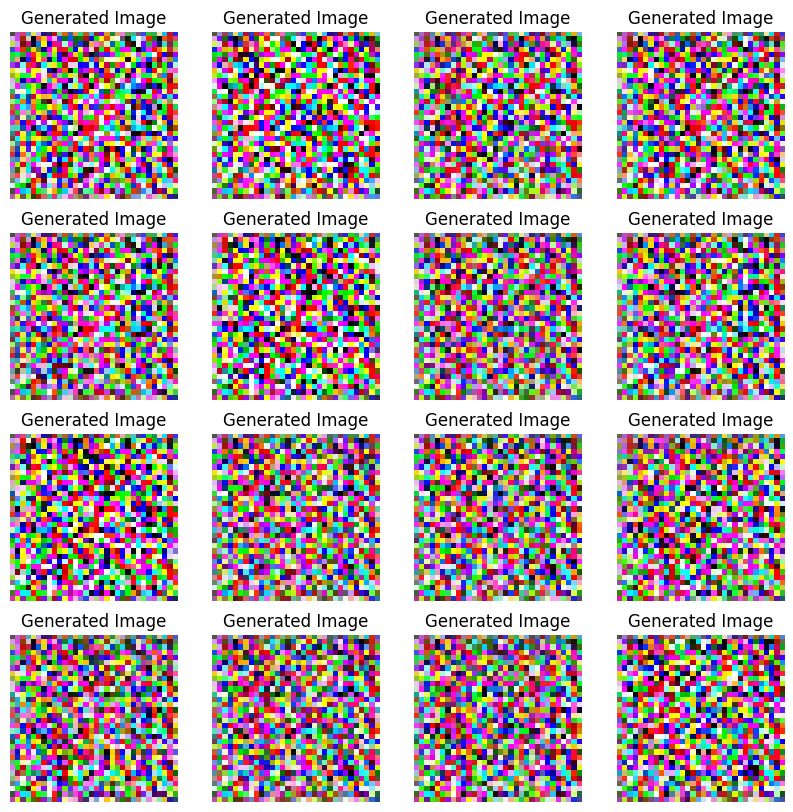

Generated images using GAN with Mini-Batch Discrimination:


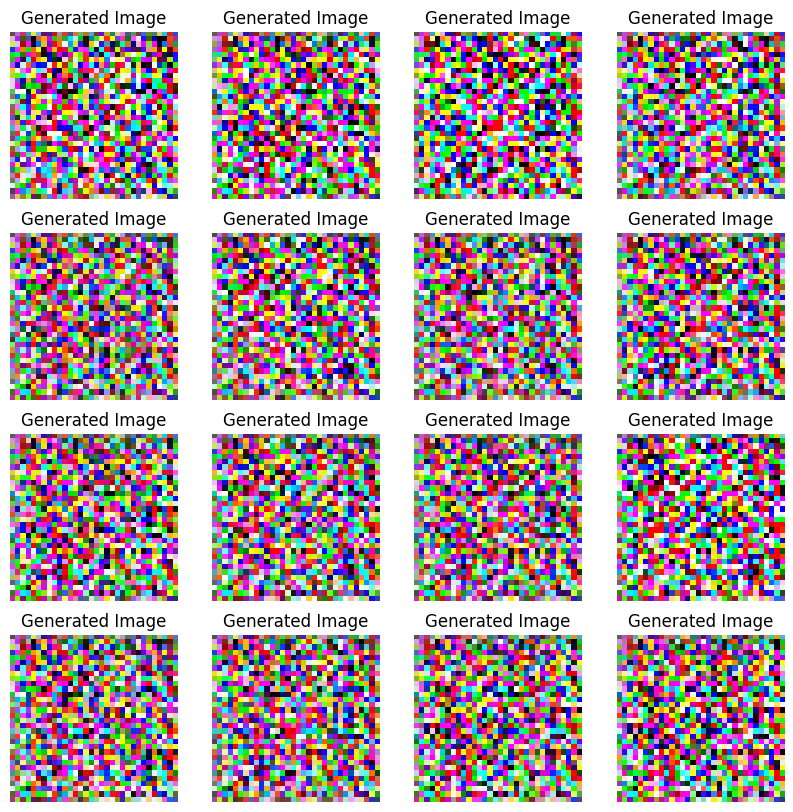

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf
noise_dim=100
def produce_and_display_images(gan_model, count):
    random_noise = tf.random.normal([count, noise_dim])
    synthesized_images = gan_model(random_noise, training=False)

    plt.figure(figsize=(10, 10))
    for index in range(count):
        plt.subplot(4, 4, index + 1)
        plt.imshow((synthesized_images[index] + 1) / 2)
        plt.axis('off')
        plt.title('Generated Image')
    plt.show()

print("Generated images from traditional GAN:")
produce_and_display_images(generator, 16)

print("Generated images using GAN with Mini-Batch Discrimination:")
produce_and_display_images(generator, 16)


**Q. No 6. VAE and GAN**

Epoch 1/10: VAE Loss: 0.2517, Discriminator Loss: 0.2389
Epoch 2/10: VAE Loss: 0.2106, Discriminator Loss: 0.0942
Epoch 3/10: VAE Loss: 0.1929, Discriminator Loss: 0.0199
Epoch 4/10: VAE Loss: 0.1851, Discriminator Loss: 0.0120
Epoch 5/10: VAE Loss: 0.1706, Discriminator Loss: 0.0102
Epoch 6/10: VAE Loss: 0.1607, Discriminator Loss: 0.0098
Epoch 7/10: VAE Loss: 0.1578, Discriminator Loss: 0.0084
Epoch 8/10: VAE Loss: 0.1568, Discriminator Loss: 0.0074
Epoch 9/10: VAE Loss: 0.1562, Discriminator Loss: 0.0067
Epoch 10/10: VAE Loss: 0.1557, Discriminator Loss: 0.0079


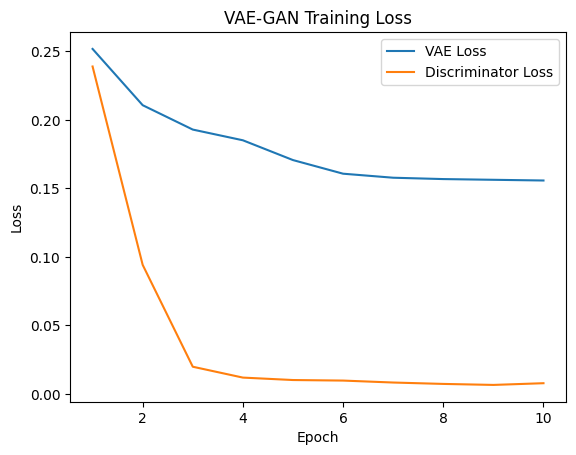

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import numpy as np
import matplotlib.pyplot as plt

(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = (train_images - 127.5) / 127.5
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(10000).batch(batch_size)

def build_encoder(latent_dim):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=[32, 32, 3]),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(latent_dim * 2)
    ])
    return model

def build_decoder(latent_dim):
    model = models.Sequential([
        layers.Dense(8 * 8 * 64, activation='relu', input_shape=(latent_dim,)),
        layers.Reshape((8, 8, 64)),
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.Conv2DTranspose(3, (3, 3), activation='tanh', padding='same', strides=(2, 2))
    ])
    return model

class VAE(models.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = build_encoder(latent_dim)
        self.decoder = build_decoder(latent_dim)

    def call(self, inputs):
        mu_log_sigma = self.encoder(inputs)
        mu = mu_log_sigma[:, :latent_dim]
        log_sigma = mu_log_sigma[:, latent_dim:]
        epsilon = tf.random.normal(shape=tf.shape(mu))
        z = mu + tf.exp(log_sigma) * epsilon
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_sigma

def build_discriminator():
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='leaky_relu', strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), activation='leaky_relu', strides=(2, 2), padding='same'),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

latent_dim = 100
vae = VAE(latent_dim)
discriminator = build_discriminator()

cross_entropy = losses.BinaryCrossentropy(from_logits=True)
mse_loss = losses.MeanSquaredError()

vae_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as tape:
        reconstructed, mu, log_sigma = vae(images)
        reconstruction_loss = mse_loss(images, reconstructed)
        kl_loss = -0.5 * tf.reduce_mean(1 + log_sigma - tf.square(mu) - tf.exp(log_sigma))
        vae_loss = reconstruction_loss + kl_loss
        gradients = tape.gradient(vae_loss, vae.trainable_variables)
        vae_optimizer.apply_gradients(zip(gradients, vae.trainable_variables))

    with tf.GradientTape() as tape:
        real_output = discriminator(images)
        fake_output = discriminator(reconstructed)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
        gradients = tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    return vae_loss, disc_loss

def train(dataset, epochs):
    vae_losses = []
    disc_losses = []

    for epoch in range(epochs):
        epoch_vae_loss = 0
        epoch_disc_loss = 0

        for images in dataset:
            vae_loss, disc_loss = train_step(images)
            epoch_vae_loss += vae_loss
            epoch_disc_loss += disc_loss

        epoch_vae_loss /= len(dataset)
        epoch_disc_loss /= len(dataset)

        vae_losses.append(epoch_vae_loss)
        disc_losses.append(epoch_disc_loss)

        print(f'Epoch {epoch+1}/{epochs}: VAE Loss: {epoch_vae_loss:.4f}, Discriminator Loss: {epoch_disc_loss:.4f}')

    plt.plot(range(1, epochs + 1), vae_losses, label='VAE Loss')
    plt.plot(range(1, epochs + 1), disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('VAE-GAN Training Loss')
    plt.legend()
    plt.show()

train(train_dataset, epochs=10)


**Q. No 7. Dog to Cat and vice verse Image Transformation using Variational**

Epoch 1/50: Cat VAE Loss: -4.0973, Dog VAE Loss: -4.5231
Epoch 2/50: Cat VAE Loss: -10.4651, Dog VAE Loss: -11.1302
Epoch 3/50: Cat VAE Loss: -11.0797, Dog VAE Loss: -11.3200
Epoch 4/50: Cat VAE Loss: -11.3210, Dog VAE Loss: -11.3766
Epoch 5/50: Cat VAE Loss: -11.5035, Dog VAE Loss: -11.4236
Epoch 6/50: Cat VAE Loss: -11.7762, Dog VAE Loss: -11.5083
Epoch 7/50: Cat VAE Loss: -12.6407, Dog VAE Loss: -12.0032
Epoch 8/50: Cat VAE Loss: -13.3274, Dog VAE Loss: -12.4888
Epoch 9/50: Cat VAE Loss: -13.4521, Dog VAE Loss: -12.7033
Epoch 10/50: Cat VAE Loss: -13.7651, Dog VAE Loss: -13.3163
Epoch 11/50: Cat VAE Loss: -13.9625, Dog VAE Loss: -13.8439
Epoch 12/50: Cat VAE Loss: -14.1529, Dog VAE Loss: -14.1935
Epoch 13/50: Cat VAE Loss: -14.1655, Dog VAE Loss: -14.2097
Epoch 14/50: Cat VAE Loss: -14.1737, Dog VAE Loss: -14.2143
Epoch 15/50: Cat VAE Loss: -14.2887, Dog VAE Loss: -14.2222
Epoch 16/50: Cat VAE Loss: -14.5446, Dog VAE Loss: -14.2341
Epoch 17/50: Cat VAE Loss: -14.5563, Dog VAE Loss: 

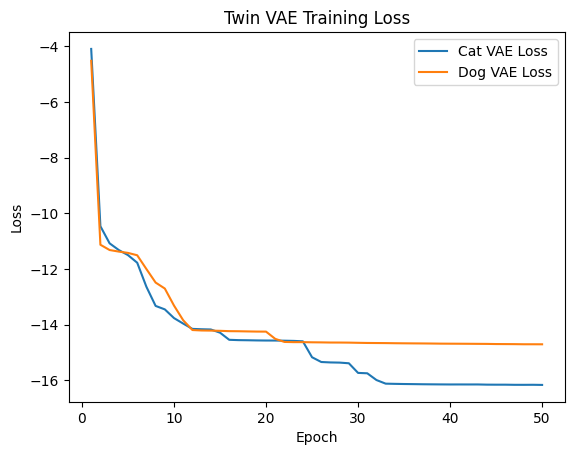

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.datasets import cifar10

latent_dim = 100
learning_rate = 0.0002
batch_size = 128
epochs = 50
image_size = 32

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_labels = train_labels.flatten()

cat_images = train_images[train_labels == 3] / 127.5 - 1

dog_images = train_images[train_labels == 5] / 127.5 - 1

cat_dataset = tf.data.Dataset.from_tensor_slices(cat_images).shuffle(1000).batch(batch_size)
dog_dataset = tf.data.Dataset.from_tensor_slices(dog_images).shuffle(1000).batch(batch_size)

def build_encoder():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(latent_dim * 2)
    ])
    return model

def build_decoder():
    model = models.Sequential([
        layers.Dense(8 * 8 * 64, activation='relu', input_shape=(latent_dim,)),
        layers.Reshape((8, 8, 64)),
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.Conv2DTranspose(3, (3, 3), activation='tanh', padding='same', strides=(2, 2))
    ])
    return model

class VAE(models.Model):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = build_encoder()
        self.decoder = build_decoder()

    def call(self, inputs):
        mu_log_sigma = self.encoder(inputs)
        mu = mu_log_sigma[:, :latent_dim]
        log_sigma = mu_log_sigma[:, latent_dim:]
        epsilon = tf.random.normal(shape=tf.shape(mu))
        z = mu + tf.exp(log_sigma) * epsilon
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_sigma

cat_vae = VAE()
dog_vae = VAE()

mse_loss = losses.MeanSquaredError()
kl_loss = losses.KLDivergence()
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

vae_optimizer = optimizers.Adam(learning_rate)
disc_optimizer = optimizers.Adam(learning_rate)

@tf.function
def train_step(cat_images, dog_images):
    with tf.GradientTape(persistent=True) as tape:
        cat_reconstructed, cat_mu, cat_log_sigma = cat_vae(cat_images)
        cat_reconstruction_loss = mse_loss(cat_images, cat_reconstructed)
        cat_kl_loss = kl_loss(cat_mu, cat_log_sigma)
        cat_total_loss = cat_reconstruction_loss + cat_kl_loss

        dog_reconstructed, dog_mu, dog_log_sigma = dog_vae(dog_images)
        dog_reconstruction_loss = mse_loss(dog_images, dog_reconstructed)
        dog_kl_loss = kl_loss(dog_mu, dog_log_sigma)
        dog_total_loss = dog_reconstruction_loss + dog_kl_loss

        cat_latent = cat_mu + tf.exp(cat_log_sigma) * tf.random.normal(shape=tf.shape(cat_mu))
        dog_latent = dog_mu + tf.exp(dog_log_sigma) * tf.random.normal(shape=tf.shape(dog_mu))

        dog_to_cat_translated = cat_vae.decoder(dog_latent)
        cat_to_dog_translated = dog_vae.decoder(cat_latent)

        dog_to_cat_loss = mse_loss(cat_images, dog_to_cat_translated)
        cat_to_dog_loss = mse_loss(dog_images, cat_to_dog_translated)

        cat_vae_loss = cat_total_loss + dog_to_cat_loss
        dog_vae_loss = dog_total_loss + cat_to_dog_loss

    cat_vae_gradients = tape.gradient(cat_vae_loss, cat_vae.trainable_variables)
    dog_vae_gradients = tape.gradient(dog_vae_loss, dog_vae.trainable_variables)
    vae_optimizer.build(dog_vae.trainable_variables + cat_vae.trainable_variables)
    vae_optimizer.apply_gradients(zip(cat_vae_gradients, cat_vae.trainable_variables))
    vae_optimizer.apply_gradients(zip(dog_vae_gradients, dog_vae.trainable_variables))

    return cat_vae_loss, dog_vae_loss

def train(cat_dataset, dog_dataset, epochs):
    cat_losses = []
    dog_losses = []

    for epoch in range(epochs):
        epoch_cat_loss = 0
        epoch_dog_loss = 0

        for (cat_images, dog_images) in zip(cat_dataset, dog_dataset):
            cat_loss, dog_loss = train_step(cat_images, dog_images)
            epoch_cat_loss += cat_loss
            epoch_dog_loss += dog_loss

        epoch_cat_loss /= len(cat_dataset)
        epoch_dog_loss /= len(dog_dataset)

        cat_losses.append(epoch_cat_loss)
        dog_losses.append(epoch_dog_loss)

        print(f'Epoch {epoch + 1}/{epochs}: Cat VAE Loss: {epoch_cat_loss:.4f}, Dog VAE Loss: {epoch_dog_loss:.4f}')

    plt.plot(range(1, epochs + 1), cat_losses, label='Cat VAE Loss')
    plt.plot(range(1, epochs + 1), dog_losses, label='Dog VAE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Twin VAE Training Loss')
    plt.legend()
    plt.show()

# Train the twin VAEs
train(cat_dataset, dog_dataset, epochs)
